# **Particle decay time simulation**
---
This notebook show how to train a QGAN to generate random variables following the distribution from the decay time of a set of particles

#### Import Libraries

In [1]:
from python_package.qGAN import Discriminator, QuantumAnsatz, QuantumGenerator, model_training
from python_package.simulations import MonteCarlo as mcs
from python_package.metrics import frechet_distance
from scipy.stats import wasserstein_distance
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch
import matplotlib.pyplot as plt

In [2]:
# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

## **Generating data**
---
The training dataset is generated through a classical Monte Carlo Simulation

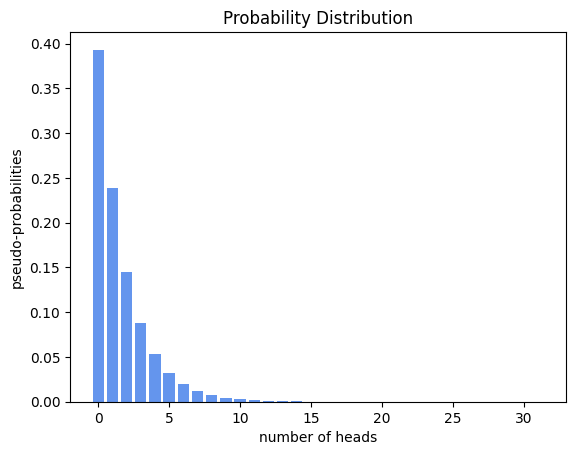

In [3]:
# particle decay time simulation
particles = mcs.particle_decay(n_particles=1000000, decay_constant=0.5)

# Get the pseudo probability distribution
prob_dist = mcs.probability_distribution_1D(samples=particles, batch_size=10000, bins=32)

# Visualize the probability distribution of the simulated data
mcs.visualize_distribution_1D(samples=particles, bins=32, xlabel="number of heads")


## **Parametrized Quantum Circuit**

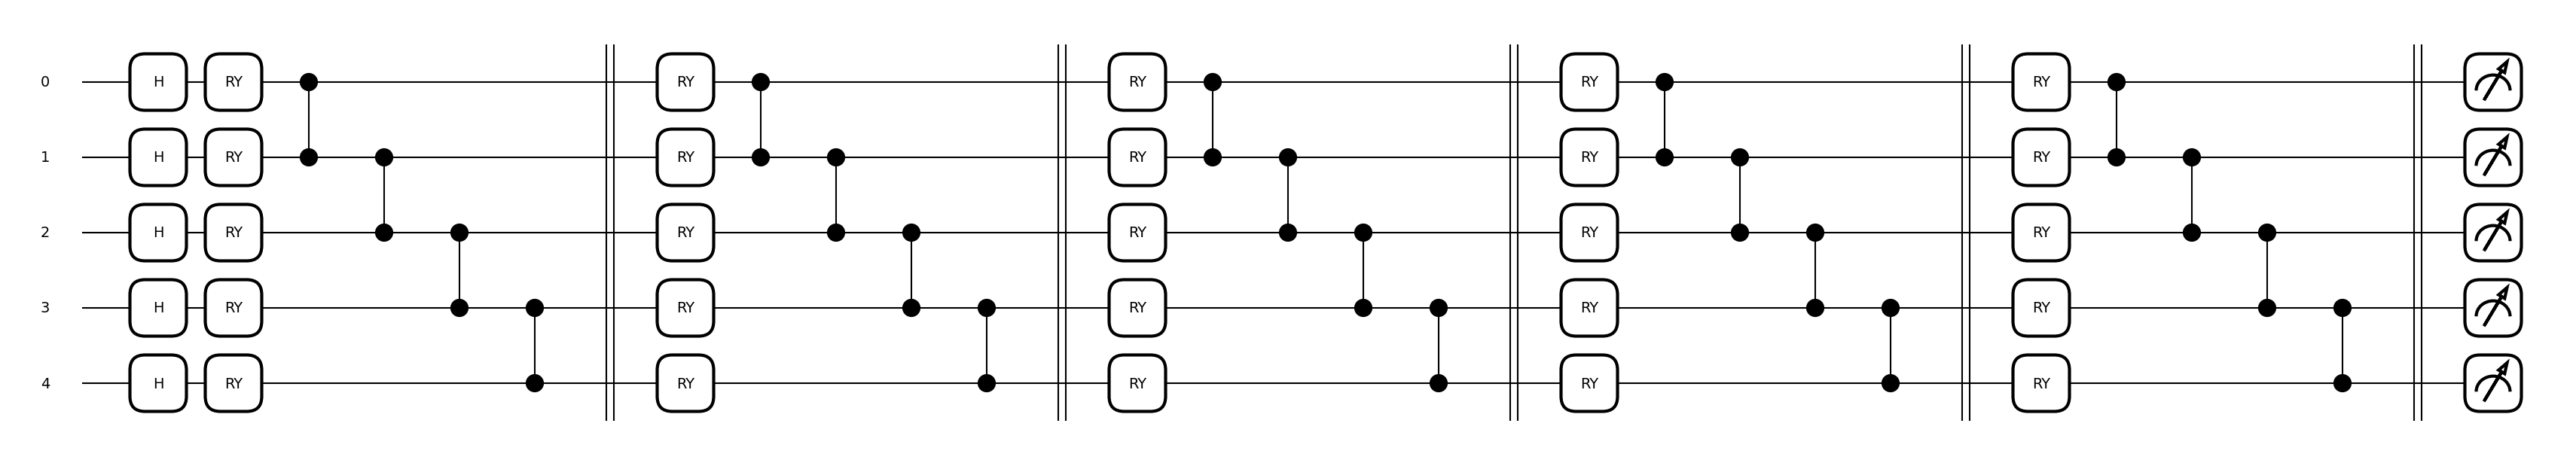

In [4]:
n_qubits = 5 # Number of qubits in the circuit
a_qubits = 0 # Number of auxiliar qubits
q_depth = 5 # Number of layers in the circuit

# Visualization of the parametrized circuit
ansatz = QuantumAnsatz(n_qubits, q_depth)
ansatz.plot_circuit()

## **Generator and Discriminator**
---
A Quantum generator and a classical discriminator are used in this implementation

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialization of classical discriminator and Quantum generator
discriminator = Discriminator(input_shape=32, 
                              layers=[50, 20]).to(device)

generator = QuantumGenerator(total_qubits=n_qubits,
                             auxiliar_qubits=a_qubits,
                             circuit_depth=q_depth,
                             quantum_circuit=ansatz.circuit()).to(device)


# Discriminator features 
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=32, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=20, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


## **Training**

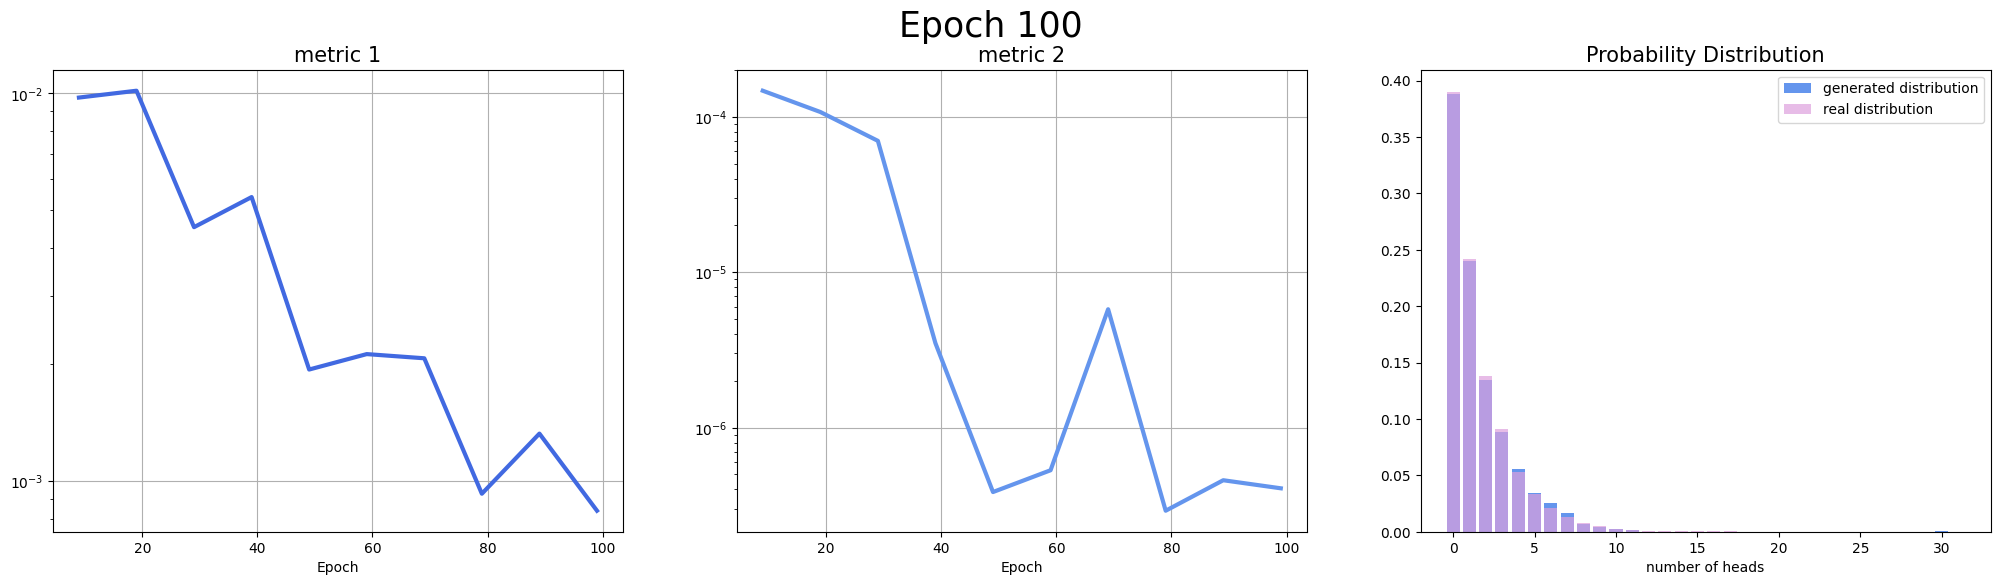

In [6]:
lrG = 0.1  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator

model_training(
    discriminator=discriminator, # Discriminator instance
    generator=generator, # Quantum generator instance
    probability_distribution=prob_dist, # Real data
    dist_shape=(32,),  # shape of the probability distribution
    device=device,  # Device to train
    criterion=nn.BCELoss(), # Loss function
    disc_optimizer=optim.SGD(discriminator.parameters(), lr=lrD),   
    gen_optimizer=optim.SGD(generator.parameters(), lr=lrG),   
    metrics=[wasserstein_distance, frechet_distance],
    epochs=100,
    batch_size=1
)

## **Results**
---
Once trained, the parametrized quantum circuit is used as a rolling two dice simulator, to fit better the real distribution, the states which do not correspopnd to any possible result are excluded from the generation, then the generator never returns an "impossible" state.

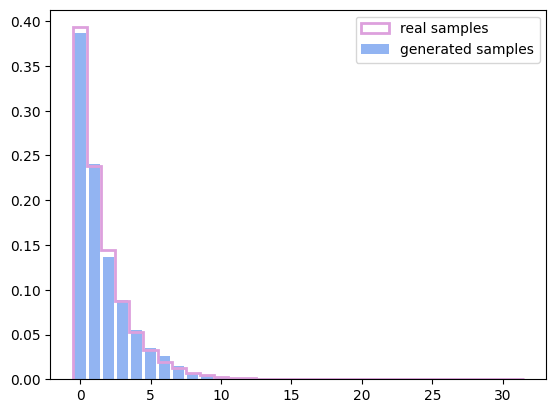

In [7]:
# Exclude states from the sampling
excluded_states = []
gen = generator.filtered_distribution(shots=100000, excluded_states=excluded_states)

# Visualize distributions
plt.hist(particles, bins=32, range=[0, 32], align='left', rwidth=0.8, density=True, color="plum", label="real samples", histtype="step", linewidth=2)
plt.hist(gen, bins=32, range=[0, 32], align='left', rwidth=0.8, density=True, color="cornflowerblue", alpha=0.7, label="generated samples")
plt.legend()
plt.show()

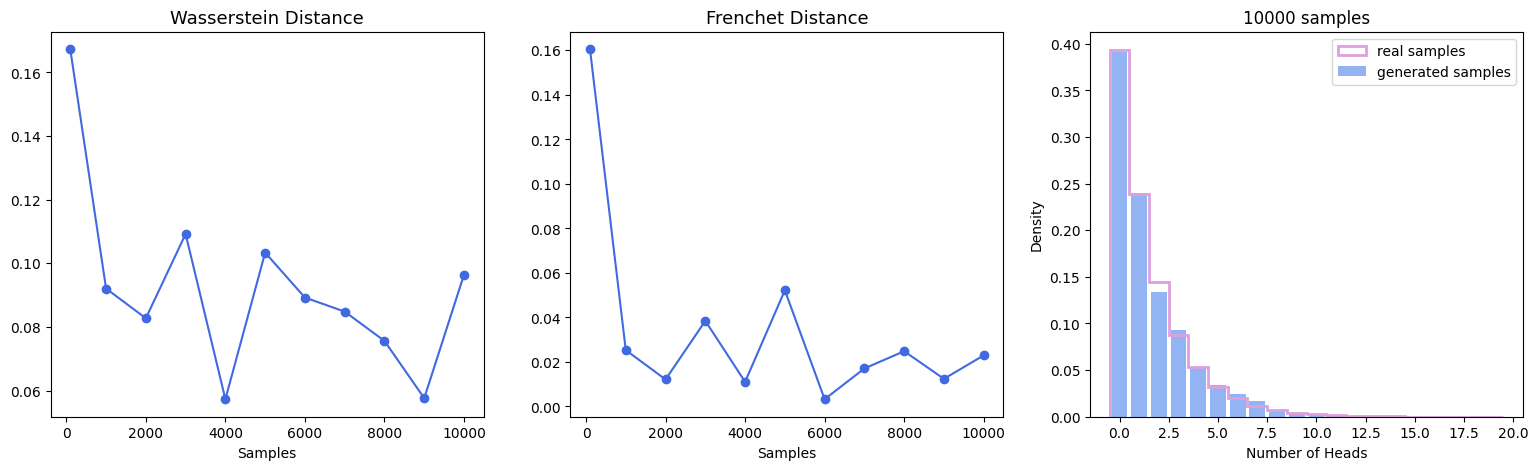

In [8]:
excluded_states = []
N_samples = [100, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
w_distance = []
f_distance = []
entropy_metric = []

for n in N_samples:
    real_samples = mcs.particle_decay(n_particles=1000000, decay_constant=0.5)
    gen_samples = generator.filtered_distribution(shots=n, excluded_states=excluded_states)
    w_distance.append(wasserstein_distance(real_samples, gen_samples)) 
    f_distance.append(frechet_distance(real_samples, gen_samples))

real_samples = mcs.particle_decay(n_particles=1000000, decay_constant=0.5)
gen_samples = generator.filtered_distribution(shots=10000, excluded_states=excluded_states)

fig, axs = plt.subplots(1, 3, figsize=(19, 5))
axs[0].plot(N_samples, w_distance, marker="o", color="royalblue")
axs[0].set_title("Wasserstein Distance", fontsize=13)
axs[0].set_xlabel("Samples", fontsize=10)
axs[1].plot(N_samples, f_distance, marker="o", color="royalblue")
axs[1].set_title("Frenchet Distance", fontsize=13)
axs[1].set_xlabel("Samples", fontsize=10)
axs[2].hist(real_samples, bins=20, align='left', range=[0, 20], rwidth=0.8, density=True, color="plum", label="real samples", histtype="step", linewidth=2)
axs[2].hist(gen_samples, bins=20, align='left', range=[0, 20], rwidth=0.8, density=True, color="cornflowerblue", alpha=0.7, label="generated samples")
axs[2].set_xlabel("Number of Heads", fontsize=10)
axs[2].set_ylabel("Density", fontsize=10)
axs[2].legend()
axs[2].set_title("10000 samples")
plt.show()